#Projeto de Ciência de dados - Predição do preço de ações da Ethereum com Machine Learning



#Formulação do problema e leitura dos dados
Nosso objetivo é estimar o preço de fechamento das ações da Ethereum utilizando conceitos de regressão linear múltipla.

Os atributos contidos nos dados:

1 - Date: Data observada em dias;

2 - Open: Preço de abertura das ações;

3 - Hight: Maior preço observado durante o dia;

4 - Low: Menor preço observado durante o dia;

5 - Close: Preço de fechamento das ações;

6 - Volume: A quantidade de dinheiro movimentada (negociada).


Os dados podem ser obtidos através do yahoo finance: https://finance.yahoo.com/quote/ETH-USD/history?p=ETH-USD e contém os valores das ações da Ethereum entre Outubro de 2020 à Outubro de 2021 em Dólares (U$D). 



#Importe as bibliotecas necessárias

In [ ]:
import random
import math
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.api as sm
from statistics import variance
from sklearn.metrics import r2_score 
from scipy.stats import t
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
!pip install fbprophet
from fbprophet import Prophet

#Visualização e Limpeza do DataSet

In [ ]:
random.seed(42)
dados = pd.read_csv('/content/ETH-USD.csv',encoding= 'utf-8',decimal = '.')
dados.tail()


,Date,Open,High,Low,Close,Adj Close,Volume
361,2021-10-28,3924.815430,4293.150879,3905.706055,4287.318848,4287.318848,25958154575
362,2021-10-29,4288.686523,4455.735352,4271.707520,4414.746582,4414.746582,22967641914
363,2021-10-30,4414.243652,4426.848633,4252.494141,4325.650391,4325.650391,14615490626
364,2021-10-31,4322.744141,4394.449707,4179.016113,4288.074219,4288.074219,17498160238
365,2021-11-01,4285.007813,4370.600586,4160.966797,4342.215820,4342.215820,18234517504


In [ ]:
dados.isnull().sum().sort_values(ascending=False) 

Volume       0
Adj Close    0
Close        0
Low          0
High         0
Open         0
Date         0
dtype: int64

Como não há valores inexistentes ou inválidos na nossa base de dados, ela não foi modificada em nada da original.

#Análise Descritiva dos dados

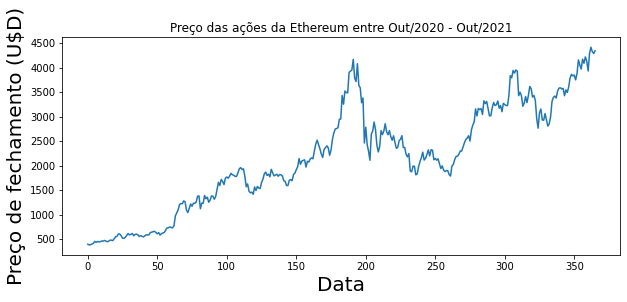

In [ ]:
plt.figure(figsize=(10, 4))
plt.title("Preço das ações da Ethereum entre Out/2020 - Out/2021")
plt.xlabel('Data', fontsize = 20) 
plt.ylabel('Preço de fechamento (U$D)', fontsize = 20) 
plt.plot(dados['Close']) 
plt.show(True)


Podemos ver que ao longo desse período de 1 ano, as ações da Ethereum apresentaram uma tendência de crescimento, apesar da repentina alavancada e queda das ações entre os dias 150 e 200.

Sumarização dos dados:

In [ ]:
dados.describe()

,Open,High,Low,Close,Adj Close,Volume
count,366.000000,366.000000,366.000000,366.000000,366.000000,3.660000e+02
mean,2158.181771,2244.009723,2067.498113,2169.064722,2169.064722,2.662417e+10
std,1063.800360,1100.617423,1026.043853,1066.129583,1066.129583,1.215037e+10
min,383.156036,389.515381,371.312744,383.156738,383.156738,8.125837e+09
25%,1382.345063,1441.171265,1301.597626,1384.794464,1384.794464,1.772856e+10
50%,2120.844849,2187.750122,2050.514648,2130.359375,2130.359375,2.353027e+10
75%,3017.566650,3181.712830,2938.802551,3037.583191,3037.583191,3.200445e+10
max,4414.243652,4455.735352,4271.707520,4414.746582,4414.746582,8.448291e+10


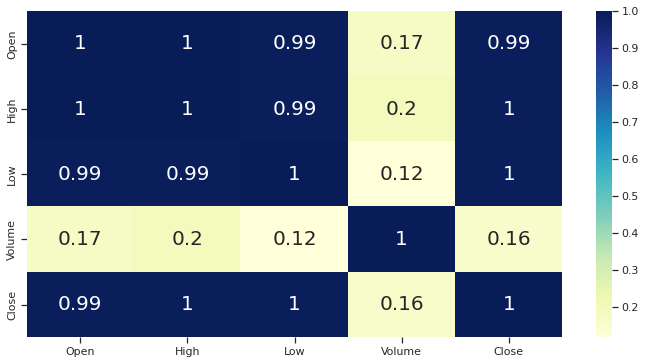

In [ ]:
dados = dados.drop(['Date','Adj Close'], axis = 1)

#Removendo atributos irrelevantes
dados = dados.reindex(columns=['Open','High','Low','Volume','Close'])
dados.describe()

sns.set_theme(style="ticks")
p = plt.figure(figsize = (12,6))
p = sns.heatmap(dados.corr(),cmap="YlGnBu",annot = True, annot_kws={'size':20})


Dado o gráfico acima, conclui-se que todos os atributos estão fortemente correlacionados entre si, exceto Volume, que praticamente não influencia em nada os outros.

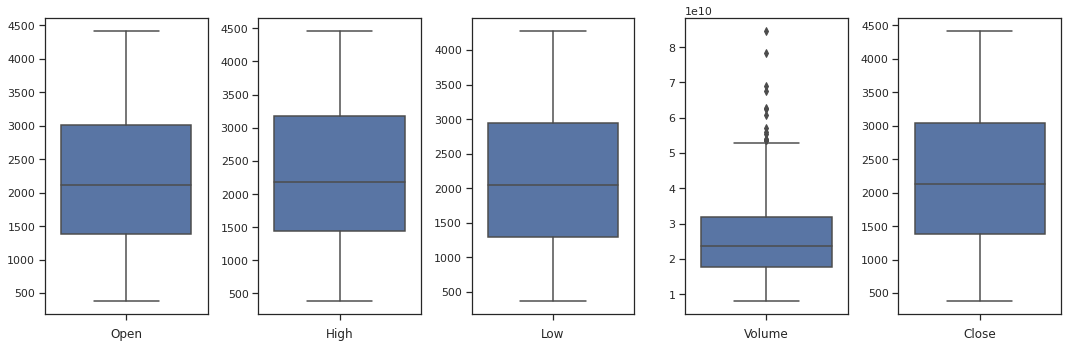

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(15,5), tight_layout=True)
plt.subplots_adjust(hspace=0.40)

for i in list(range(5)):
  sns.boxplot(y=dados[list(dados.columns)[i]], ax=axes[i]).set(xlabel=list(dados.columns)[i], ylabel='')

De todas as variáveis, "Volume" foi a que apresentou a menor variância entre os valores centrais e ao mesmo tempo foi a única que apresentou um grande número de Outliers. Isso provavelmente se deve a sua absurda diferença entre os dados, e por isso, para sabermos se ele realmente não ajuda na nossa análise, vamos normalizar os atributos e correlacioná-los novamente.

#Normalização dos dados

Primeiramente, vamos separar os dados de treino e teste.

In [ ]:
dados = dados.to_numpy()
nrow,ncol = dados.shape
y = dados[:,-1]
X = dados[:, 0:ncol-1]

y_treino = y[0:300]
y_teste = y[300:]
X_treino = X[0:300 ,:]
X_teste = X[300:,:]


Decidimos dividí-los de tal forma que tanto nosso $Y_{treino}$ quanto o $X_{treino}$ contenham os primeiros 300 dias de análise (um total de aproximadamente 82% da base de dados), e o $Y_{teste}$ e $X_{teste}$ os últimos 65 dias (ou aproximadamente 18% do total). Dessa forma, pela supremacia de dados na parte de treino, esperamos estimar bem a parte de teste.

E agora, normalizando a fim de evitar o efeito da escala do atributo volume no conjunto de treino e teste :

In [ ]:
#Normalizando para evitar o efeito da escala do atributo volume no conjunto de 
# treino e teste


scaler = StandardScaler().fit(X_treino)
X_treino = scaler.transform(X_treino)

scaler2 = StandardScaler().fit(X_teste)
X_teste = scaler2.transform(X_teste)

# np.mean(X_treino, axis = 0)
# np.mean(X_teste, axis = 0)
# np.std(X_treino, axis = 0)
# np.std(X_teste, axis = 0)

#Modelo 

In [ ]:
X_treino = sm.add_constant(X_treino)
X_teste = sm.add_constant(X_teste)

regressao = sm.OLS(y_treino,X_treino).fit()
print(regressao.summary(alpha = 0.05))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.614e+04
Date:                Fri, 26 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:27:23   Log-Likelihood:                -1586.0
No. Observations:                 300   AIC:                             3182.
Df Residuals:                     295   BIC:                             3201.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1859.7086      2.785    667.656      0.0

Como essa tabela foi gerada com os dados de treino, não podemos usar para verificar a qualidade do modelo devido a overfitting. Porém, é útil para conferir os valores dos coeficientes assim como seu intervalo de confiança. 

Como visto antes, a variável "Volume" tem uma correlação baixa não só com y mas também com as outras variáveis, dito isso, na tabela pudemos ver que seu p-valor se ultrapassa 0.5. Juntando esses fatores, iremos realizar um teste de hipótese para concluir se iremos manter "Volume" no nosso modelo antes de ajustá-lo em definitivo.

In [ ]:
beta = np.dot(np.dot(np.linalg.pinv(np.dot(X_treino.transpose(), X_treino)), X_treino.transpose()), y_treino)
print('Beta:',beta)


Beta: [1859.70857066 -533.58066998  844.82111967  588.59043629    2.39057799]


#Teste de hipótese e Predição dos Valores no conjunto de testes

Resolvemos então, utilizar um teste individual na variável "Volume", o seguinte teste foi aplicado:

$H_{0}: \beta_{j} = 0$ vs $H_{1}: \beta_{j} \neq 0 $


$t = \frac{{\widehat{\beta}_{i-1}}}{{\widehat{dp}_{i-1}}}$ $\sim$ $t_{(n-p)}$

Rejeita $H_{0}$ se $t < t(α/2, n-p)$ ou $t > t(1-α/2, n-p)$

In [ ]:
p = 5
k = 4
n = len(dados)
beta4 = beta[4]

y_transposto = y_treino.T
y_transposto_y = y_transposto.dot(y_treino)
beta_transposto = beta.T


x_transposta = X_treino.T
x_transposta_x = x_transposta.dot(X_treino)
inversa_x_transposta_x = np.linalg.inv(x_transposta_x)
x_transposta_y = x_transposta.dot(y_treino)

sigma = (y_transposto_y - (beta_transposto.dot(x_transposta_y)))/ n-p
print(sigma)

t4 = beta4/math.sqrt(sigma*inversa_x_transposta_x[4,4])

inf,sup = t.interval(0.95,n-p)

if t4 < inf or t4 > sup:
    print('Rejeita-se h0, x4 é importante para o modelo')
else:
    print('Aceita-se h0, x4 pode ser tirado do modelo')

#Concluímos que a variável volume pode ser retirada do nosso modelo de regressão 




1871.0612929877036
Aceita-se h0, x4 pode ser tirado do modelo


Com um $α = 0,05$, o teste nos mostrou que, dado que existem outras variáveis no modelo, "Volume" não nos fornece informações novas para o mantermos. Sendo assim, devendo ser descartado.

#Random Forest

Antes de modelarmos com regressão múltipla, resolvemos utiizar o algorítmo Random Forests devido a sua fácil interpretação e implementação. Com isso, poderemos comparar sua adequação com um modelo de regressão múltipla e como Random Forest nos permite identificar a importância de cada covariável, teremos outra forma de verificar a importância de "Volume" no modelo além do teste de hipótese.

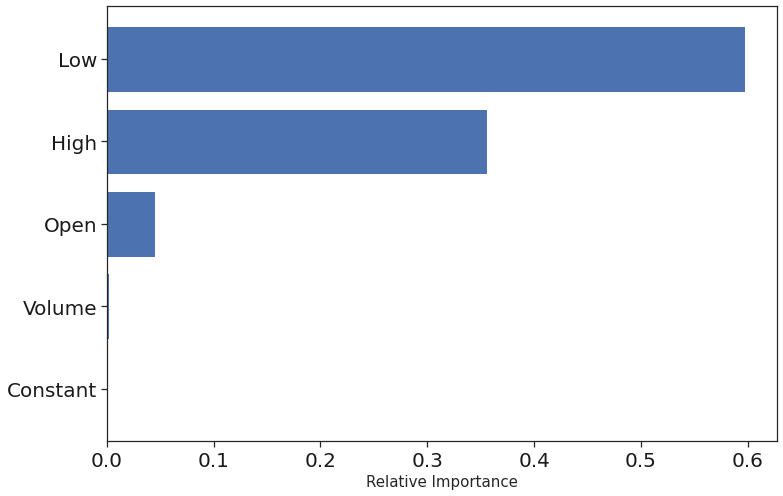

In [ ]:
modelo = RandomForestRegressor(n_estimators = 100, random_state = 0)
modelo.fit(X_treino, y_treino)  
y_pred = modelo.predict(X_teste)

features_names = ['Constant','Open','High','Low','Volume']

importances = modelo.feature_importances_
indices = np.argsort(importances)
lmeas_order = []
for i in indices:
    lmeas_order.append(features_names[i])
plt.figure(figsize=(12,8))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), lmeas_order, fontsize=15)
plt.xlabel('Relative Importance',fontsize=15)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show()


Como visto no gráfico acima, a constante do modelo de regressão não possui variável indexada, logo é natural que sua importância relativa seja zero. Porém, "Volume" apresentou importância relativa muito abaixa das demais, sendo quase nula. Logo, além do teste de hipótese, que já seria mais que suficiente para retirarmos essa variável, temos o algorítmo que nos confirma essa necessidade.

Reformulando o conjunto de dados agora sem a variável "Volume" para o novo modelo, novamente iremos dividir o conjunto entre treinamento e teste, sendo os 300 primeiros dias os dados de treino e os 65 últimos o teste.

In [ ]:
#Removendo a última coluna Volume do modelo
newdados = pd.read_csv('/content/ETH-USD.csv',encoding= 'utf-8',decimal = '.')

newdados = newdados.drop(['Date','Adj Close','Volume'], axis = 1)

#Removendo atributos irrelevantes
newdados = newdados.reindex(columns=['Open','High','Low','Close'])

newdados = newdados.to_numpy()
nrow,ncol = newdados.shape
y = newdados[:,-1]
X = newdados[:, 0:ncol-1]

y_treino = y[0:300]
y_teste = y[300:]
X_treino = X[0:300 ,:]
X_teste = X[300:,:]

X_treino = sm.add_constant(X_treino)
X_teste = sm.add_constant(X_teste)


Agora, iremos comparar os valores de $R_{2}, R_{2ajustado}$ e $EQM$ entre o modelo ajustado com Random Forest e o ajustado com Linear Regression e verificarmos qual é o mais adequado.

#Avaliação do modelo

In [ ]:
modelo = RandomForestRegressor(n_estimators = 100, random_state = 0)
modelo.fit(X_treino, y_treino)  
y_pred = modelo.predict(X_teste)

R2 = r2_score(y_teste, y_pred)
print('R2:', R2)

adjusted_R2 = 1 - (1-R2)*(len(y_teste)-1)/(len(y_teste)-X_teste.shape[1]-1) 
print('Adjusted R2:', adjusted_R2)

error = mean_squared_error(y_teste,y_pred)
print('Erro Quadrático médio:', error)

R2: 0.8604806048925406
Adjusted R2: 0.8513317920986089
Erro Quadrático médio: 24457.254873743925


In [ ]:
#Ajuste
modelo = LinearRegression().fit(X_treino,y_treino)
y_predito = modelo.predict(X_teste)


In [ ]:
R2 = r2_score(y_teste, y_predito)
print('R2:', R2)

error = mean_squared_error(y_teste,y_predito)
print('Erro Quadrático médio:', error)

adjusted_R2 = 1 - (1-R2)*(len(y_teste)-1)/(len(y_teste)-X_teste.shape[1]-1) 
print('Adjusted R2:', adjusted_R2)


R2: 0.9762974007663054
Erro Quadrático médio: 4154.981536310295
Adjusted R2: 0.974743131964096


Como podemos ver, o modelo com Linear Regression apresenta não só um coeficiente $R_{2}$ mais alto como também um Erro Quadrático médio menor. Visto isso, é o modelo mais adequado para a predição dos valores.

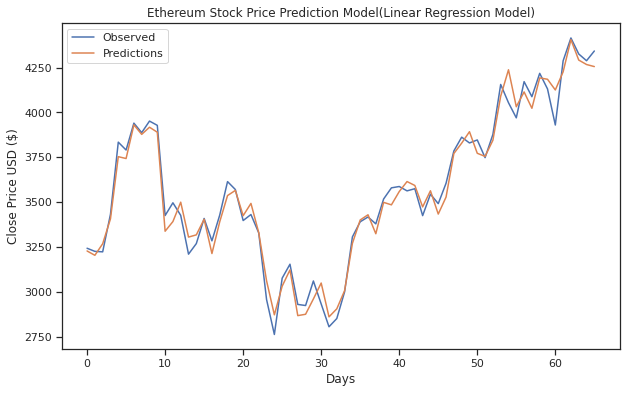

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Ethereum Stock Price Prediction Model(Linear Regression Model)")
plt.xlabel("Days")
plt.ylabel("Close Price USD ($)")
plt.plot(y_teste)
plt.plot(y_predito)
plt.legend(["Observed", "Predictions"])
plt.show()

Ao comparar os valores preditos com os observados no treinamento, percebe-se que o ajuste está adequado ao modelo.

#Análise dos resíduos

Agora, iremos verificar o comportamento dos resíduos no modelo para identificar possível viés ou desordem.

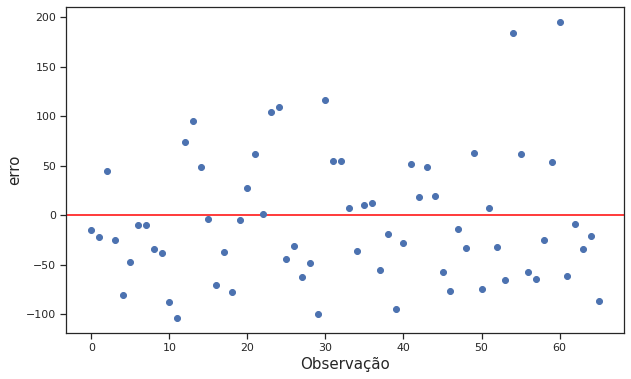

In [ ]:
e = np.array(y_predito - y_teste)
t = np.arange(0,len(e))
plt.figure(figsize=(10,6))
plt.axhline(y=0, color = 'red')
plt.plot(t,e,'o')
plt.ylabel("erro", fontsize=15)
plt.xlabel("Observação", fontsize=15)

plt.show(True)

Os resíduos estão aleatóriamente distribuídos em torno de zero, e não há indícios de autocorrelação ou necessidade de transformações em Y. 

#Conclusão

O modelo é adequado para prever valores da empresa Ethereum. Porém, como se trata de uma previsão futura, um problema inicialmente de séries temporais, precisamos de informações como o preço de abertura, alta e baixa das ações, informações essas que precisam ser estimadas para se obter precisão. Caso o interesse seja prever no mesmo dia o preço de fechamento das ações, o valor será mais preciso a medida que o dia se aproxima de seu fim. Mas, esse cenário não é de grande utilidade, então é de se esperar que a precisão diminua.

#Transformando séries temporais em um modelo de regressão (Teste)

No teste abaixo, utilizamos outra abordagem, tranformamos o preço de fechamento das ações "Close" em uma variável de entrada, em seguida, copiamos a mesma coluna para variável Y e em seguida fizemos um deslocamento, dessa forma, X é o preço de fechamento do dia atual e Y será nosso preço de fechamento do dia seguinte.

O objetivo dessa abordagem foi prever o dia seguinte baseado nos dados dos 3 últimos dias utilizando regressão múltipla.

R2: 0.6314178556315916


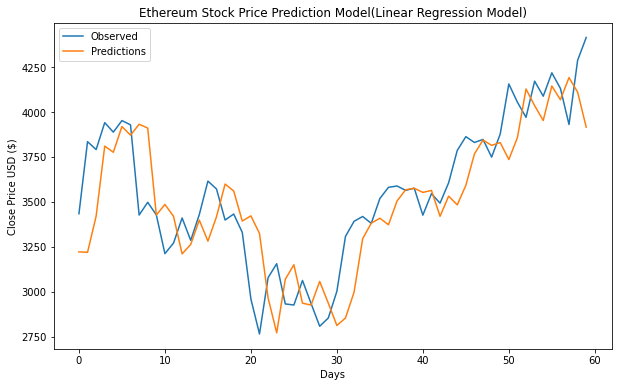

In [42]:
eth = pd.read_csv('/content/ETH-USD.csv',encoding= 'utf-8',decimal = '.')
eth.tail()

eth = eth[['Close']]
eth['t+1'] = eth[['Close']].shift(-1)
eth['t+2'] = eth[['Close']].shift(-2)
eth['t+3'] = eth[['Close']].shift(-3)

eth = eth.rename(columns = {"Close":"t-2","t+1":"t-1",'t+2':'t','t+3':'Prediction'})
#print(eth)
eth = eth.to_numpy()

#Remove NaN
eth = eth[:-3][:-3]
#print(eth)

X_train = eth[:300,0:2]
#X_train = X_train.reshape(-1,1)

X_test = eth[300:,0:2]
#X_test = X_test.reshape(-1,1)

y_train = eth[:300,-1]
#y_train = y_train.reshape(-1,1)

y_test = eth[300:,-1]
#y_test = y_test.reshape(-1,1)

model = LinearRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)

R2 = r2_score(y_test, y_pred)
print('R2:', R2)


plt.figure(figsize=(10, 6))
plt.title("Ethereum Stock Price Prediction Model(Linear Regression Model)")
plt.xlabel("Days")
plt.ylabel("Close Price USD ($)")
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(["Observed", "Predictions"])
plt.show()


O resultado mostrado no gráfico se mostrou satisfatório e de certa forma útil quando pensamos em prever apenas o dia seguinte. Contudo, é por ser uma predição, é natural que seu coeficiente R2 não seja tão alto quando comparamos com o modelo anterior.

#Facebook Prophet

Nessa abordagem, resolvemos utilizar a ferramenta de machine learning do facebook chamado "Prophet", é um modelo que ajusta dados não lineares e ajusta tendências de sazonalidade anuais, mensais, semanais, diáris e até mesmo efeitos de feriados. Visto isso, séries temporais em que esses efeitos tem forte influência funcionam de modo mais adequado.

In [ ]:
data = pd.read_csv('/content/ETH-USD.csv',encoding= 'utf-8',decimal = '.')
data.tail()

data = data[["Date","Close"]]
data = data.rename(columns = {"Date":"ds","Close":"y"})

# data_train = data.iloc[:300,]
# data_test = data.iloc[300:,]

model = Prophet(daily_seasonality = True, weekly_seasonality= True)
model.fit(data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Dessa forma, utilizamos todo o conjunto de dados para prever 30 dias no futuro.

Percebe-se uma tendência de que durante o mês de dezembro de 2021 as ações da ethereum irão aumentar o seu valor de forma crescente. Claro que, devido a inúmeros fatores, não será um crescimento linear como o modelo apresenta. A sombra em azul é o intervalo de confiança.

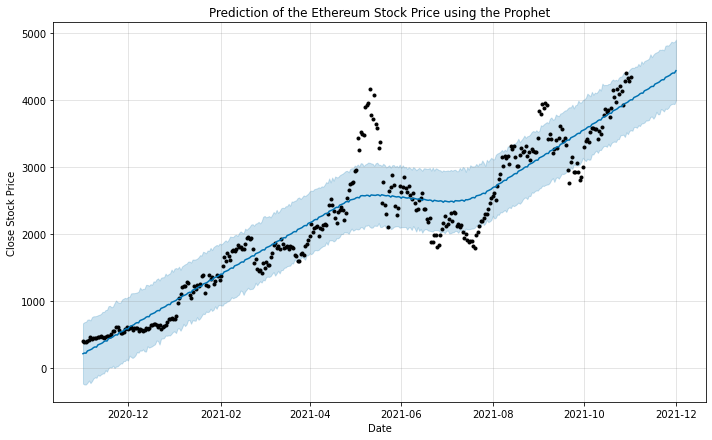

In [ ]:
future = model.make_future_dataframe(periods=30)
#print(future)

prediction = model.predict(future)
model.plot(prediction)
plt.title("Prediction of the Ethereum Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

Com o prophet, podemos ser capazes de analisar comportamentos periódicos,  Pelo gráfico, vemos que o dia de maior alta das ações são na quarta-feira (provavelmente o dia onde ocorre maior compra de ações) e de terça-feira o dia de maior baixa. Ademais, durante o dia as 3 horas que antedecem o fim do dia e sucedem o começo do dia são os horários de maior pico no preço

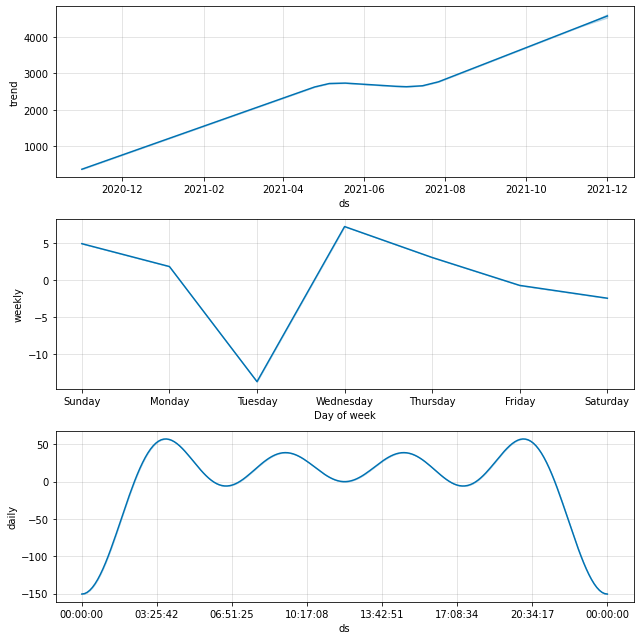

In [ ]:
model.plot_components(prediction)
plt.show()
